In [ ]:
cd '/content/drive/MyDrive/Road_Sign_Dataset'

/content/drive/MyDrive/Road_Sign_Dataset


In [ ]:
pwd

'/content/drive/MyDrive/Road_Sign_Dataset'

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9484, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 9484 (delta 2), reused 7 (delta 1), pack-reused 9473
Receiving objects: 100% (9484/9484), 9.90 MiB | 5.96 MiB/s, done.
Resolving deltas: 100% (6590/6590), done.
Checking out files: 100% (96/96), done.


In [ ]:
!pip install -r yolov5/requirements.txt

In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [ ]:
!unzip '/content/drive/MyDrive/Road_Sign_Dataset/RoadSignsPascalVOC.zip'

Archive:  /content/drive/MyDrive/Road_Sign_Dataset/RoadSignsPascalVOC.zip
replace __MACOSX/._annotations? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:
print(extract_info_from_xml('/content/drive/MyDrive/Road_Sign_Dataset/annotations/road100.xml'))

FileNotFoundError: ignored

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("/content/drive/MyDrive/Road_Sign_Dataset/annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Get the annotations
annotations = [os.path.join('/content/drive/MyDrive/Road_Sign_Dataset/annotations', x) for x in os.listdir('/content/drive/MyDrive/Road_Sign_Dataset/annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('/content/drive/MyDrive/Road_Sign_Dataset/annotations', x) for x in os.listdir('/content/drive/MyDrive/Road_Sign_Dataset/annotations') if x[-3:] == "txt"]

FileNotFoundError: ignored

In [ ]:
random.seed(5)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

NameError: ignored

In [ ]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [ ]:
!mv annotations labels
!cd '/content/drive/MyDrive/Road_Sign_Dataset/yolov5'

In [ ]:
!wget -P data/ https://gist.githubusercontent.com/ayooshkathuria/bcf7e3c929cbad445439c506dba6198d/raw/f437350c0c17c4eaa1e8657a5cb836e65d8aa08a/road_sign_data.yaml

--2021-10-06 10:56:19--  https://gist.githubusercontent.com/ayooshkathuria/bcf7e3c929cbad445439c506dba6198d/raw/f437350c0c17c4eaa1e8657a5cb836e65d8aa08a/road_sign_data.yaml
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220 [text/plain]
Saving to: ‘data/road_sign_data.yaml.1’

road_sign_data.yaml 100%[===================>]     220  --.-KB/s    in 0s      

2021-10-06 10:56:19 (7.36 MB/s) - ‘data/road_sign_data.yaml.1’ saved [220/220]



In [ ]:
cd '/content/drive/MyDrive/Road_Sign_Dataset/yolov5/utils'

/content/drive/MyDrive/Road_Sign_Dataset/yolov5/utils


In [ ]:
cd '/content/drive/MyDrive/Road_Sign_Dataset'

/content/drive/MyDrive/Road_Sign_Dataset


In [ ]:
!python ./yolov5/train.py --img 540 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 2 --data road_sign_data.yaml --weights yolov5s.pt --workers 24 --name yolo_road_det

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=road_sign_data.yaml, hyp=hyp.scratch.yaml, epochs=2, batch_size=32, imgsz=540, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=yolov5/runs/train, name=yolo_road_det, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2021-10-6 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=

In [ ]:
!python ./yolov5/detect.py --source ./images/test --weights ./yolov5/runs/train/yolo_road_det/weights/best.pt  --name yolo_road_det

detect: weights=['./yolov5/runs/train/yolo_road_det/weights/best.pt'], source=./images/test, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_road_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-496-g070af88 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 224 layers, 7062001 parameters, 0 gradients, 16.4 GFLOPs
image 1/88 /content/drive/My Drive/Road_Sign_Dataset/images/test/road100.png: 640x640 Done. (0.022s)
image 2/88 /content/drive/My Drive/Road_Sign_Dataset/images/test/road113.png: 448x640 Done. (0.019s)
image 3/88 /content/drive/My Drive/Road_Sign_Dataset/images/test/road129.png: 448x640 Done. (0.018s)
image 4/88 /content/drive/My Drive/Road_Sign_Dataset/images/test/road140

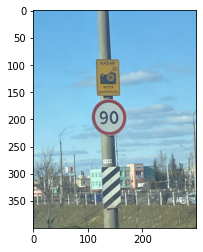

In [ ]:
detections_dir = "./yolov5/runs/detect/yolo_road_det5/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [ ]:
!python ./yolov5/test.py --weights ./yolov5/runs/train/yolo_road_det37/weights/best.pt --data road_sign_data.yaml --task test --name yolo_det

python3: can't open file './yolov5/test.py': [Errno 2] No such file or directory
